<a href="https://colab.research.google.com/github/ToukaNour30/VGG-16/blob/main/VGG_trial1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib scikit-learn

In [ ]:
!pip install kaggle tensorflow numpy matplotlib scikit-learn

In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"<toukanour >", "key":"<your_kaggle_api_key>"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d rm1000/brain-tumor-mri-scans


mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
brain-tumor-mri-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_path = "/content/brain-tumor-mri-scans.zip"  # Update the path if different
extract_path = "/content/brain-tumor-mri-scans"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")

Dataset extracted!


In [ ]:
import os

# Path to the extracted dataset
dataset_path = "/content/brain-tumor-mri-scans"

# Verify the contents of the dataset
print("Available files and folders:")
print(os.listdir(dataset_path))


Available files and folders:
['meningioma', 'healthy', 'glioma', 'pituitary']


In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import numpy as np


In [ ]:
dataset_path = "/content/brain-tumor-mri-scans"  # Update with your dataset path
categories = ['healthy', 'glioma', 'meningioma', 'pituitary']

# Parameters
img_size = (224, 224)  # Input size for VGG
batch_size = 64

# Function to load and preprocess images
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming the images are in JPEG format
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to get dataset
def get_dataset(dataset_path, categories):
    image_paths = []
    labels = []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        label = categories.index(category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            image_paths.append(img_path)
            labels.append(label)

    return image_paths, labels

# Load the image paths and labels
image_paths, labels = get_dataset(dataset_path, categories)

# Split into train and test (70% for training, 30% for testing)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# Create TensorFlow dataset for train and test
def create_tf_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Mapping function to load and preprocess images
    dataset = dataset.map(lambda img_path, label: (load_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch to improve performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create train and test datasets
train_ds = create_tf_dataset(train_paths, train_labels)
test_ds = create_tf_dataset(test_paths, test_labels)

# Print shapes of train and test datasets (number of batches)
print(f"Train dataset batches: {len(train_paths) // batch_size}")
print(f"Test dataset batches: {len(test_paths) // batch_size}")


Train dataset batches: 76
Test dataset batches: 32


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

# Resizing and preprocessing images for VGG
def preprocess_image(img_path):
    # Load the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming images are in JPEG format
    img = tf.image.resize(img, (224, 224))  # Resize to (224, 224)
    img = preprocess_input(img)  # Preprocess the image for VGG
    return img

# Apply preprocessing to the datasets
def create_vgg_dataset(image_paths, labels, batch_size=64):
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map function to load, resize, and preprocess the images
    dataset = dataset.map(lambda img_path, label: (preprocess_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Convert labels to one-hot encoding for VGG (assuming 4 classes in your dataset)
train_labels_one_hot = to_categorical(train_labels, num_classes=4)  # Change `num_classes=4` if necessary
test_labels_one_hot = to_categorical(test_labels, num_classes=4)

# Create the VGG-compatible datasets
train_ds_vgg = create_vgg_dataset(train_paths, train_labels_one_hot)
test_ds_vgg = create_vgg_dataset(test_paths, test_labels_one_hot)

# Print shapes of train and test datasets
print(f"Train dataset batches: {len(train_paths) // 64}")
print(f"Test dataset batches: {len(test_paths) // 64}")


Train dataset batches: 76
Test dataset batches: 32


In [ ]:
# Print the shape of a batch from the train and test datasets
for images, labels in train_ds.take(1):  # Take one batch
    print(f"Train images batch shape: {images.shape}")
    print(f"Train labels batch shape: {labels.shape}")

for images, labels in test_ds.take(1):  # Take one batch
    print(f"Test images batch shape: {images.shape}")
    print(f"Test labels batch shape: {labels.shape}")


Train images batch shape: (64, 224, 224, 3)
Train labels batch shape: (64,)
Test images batch shape: (64, 224, 224, 3)
Test labels batch shape: (64,)


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


In [ ]:
fine_tune = 0
if fine_tune > 0:
  for layer in base_model.layers[:-fine_tune]:
    layer.trainable = False
else:
  for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to preprocess images
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming JPEG format
    img = tf.image.resize(img, (224, 224))  # Resize to (224, 224)
    img = preprocess_input(img)  # Apply VGG-specific preprocessing
    return img

# Create the dataset with preprocessing
def create_vgg_dataset(image_paths, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Apply preprocessing to each image
    dataset = dataset.map(lambda img_path, label: (preprocess_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch the dataset for better performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Apply the dataset creation function to both train and test datasets
train_ds_vgg = create_vgg_dataset(train_paths, train_labels_one_hot)
test_ds_vgg = create_vgg_dataset(test_paths, test_labels_one_hot)

# Print shapes of the batches
for images, labels in train_ds_vgg.take(1):
    print(f"Train batch images shape: {images.shape}")
    print(f"Train batch labels shape: {labels.shape}")

for images, labels in test_ds_vgg.take(1):
    print(f"Test batch images shape: {images.shape}")
    print(f"Test batch labels shape: {labels.shape}")


Train batch images shape: (64, 224, 224, 3)
Train batch labels shape: (64, 4)
Test batch images shape: (64, 224, 224, 3)
Test batch labels shape: (64, 4)


In [ ]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(4, activation='softmax')
])

 **without early stopping**

In [ ]:

def split_dataset(dataset, validation_split=0.2):
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

# Split the datasets into train and validation datasets
train_ds_split, val_ds_split = split_dataset(train_ds_vgg, validation_split=0.2)

# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
history = model.fit(
    train_ds_split,  # Train dataset
    epochs=20,
    validation_data=val_ds_split,  # Validation dataset
   # callbacks=[es]
)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 958ms/step - accuracy: 0.6879 - loss: 2.3692 - val_accuracy: 0.9061 - val_loss: 0.2968
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - accuracy: 0.9475 - loss: 0.1587 - val_accuracy: 0.9335 - val_loss: 0.2336
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.9847 - loss: 0.0427 - val_accuracy: 0.9409 - val_loss: 0.1979
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 620ms/step - accuracy: 0.9913 - loss: 0.0238 - val_accuracy: 0.9272 - val_loss: 0.2409
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step - accuracy: 0.9935 - loss: 0.0241 - val_accuracy: 0.9515 - val_loss: 0.1973
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.9920 - loss: 0.0177 - val_accuracy: 0.9357 - val_loss: 0.3121
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.9880 - loss: 0.0413 - val_accuracy: 0.9641 - val_loss: 0.1497
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 579ms/step - accuracy: 0.9972 - loss: 0.0071 - val_accu

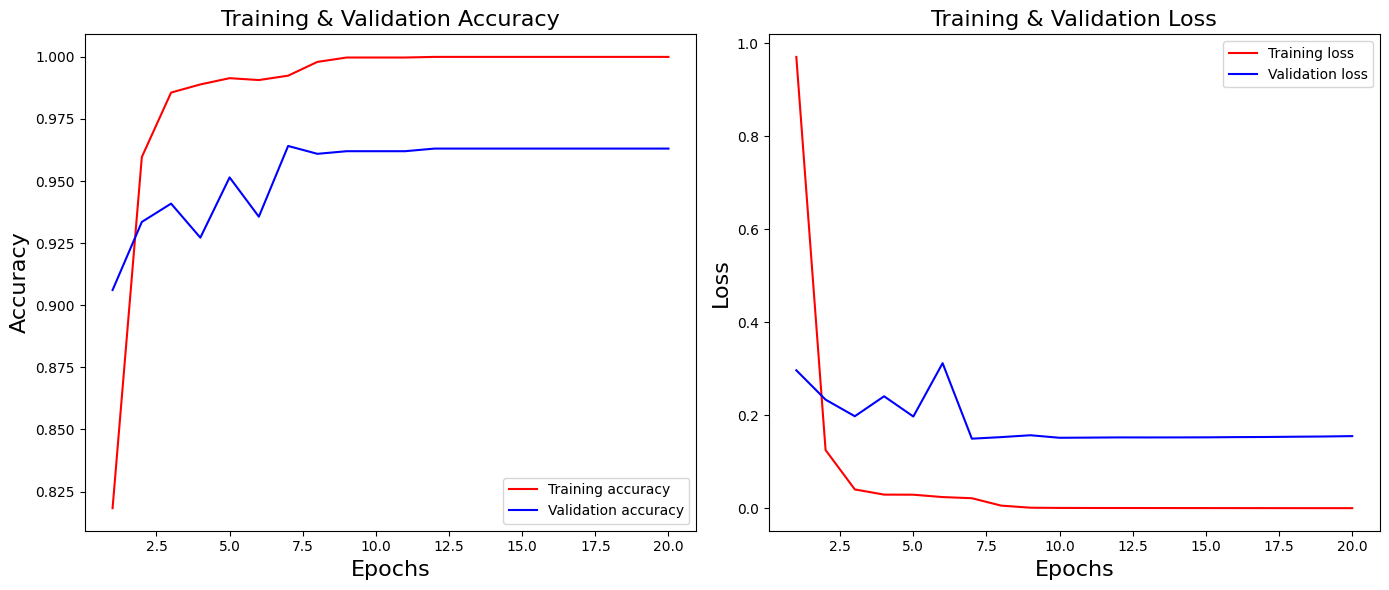

In [ ]:
if history and hasattr(history, 'history'):
    # Extract the history dictionary
    history_dict = history.history

    # Ensure the metrics exist in the history dictionary
    loss_values = history_dict.get('loss', [])
    val_loss_values = history_dict.get('val_loss', [])
    accuracy = history_dict.get('accuracy', [])
    val_accuracy = history_dict.get('val_accuracy', [])

    # Check if metrics are available
    if not loss_values or not val_loss_values or not accuracy or not val_accuracy:
        print("Training history does not contain all required metrics.")
    else:
        # Define the range of epochs
        epochs = range(1, len(loss_values) + 1)

        # Create subplots for accuracy and loss
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot Training & Validation Accuracy
        ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
        ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        ax[0].set_title('Training & Validation Accuracy', fontsize=16)
        ax[0].set_xlabel('Epochs', fontsize=16)
        ax[0].set_ylabel('Accuracy', fontsize=16)
        ax[0].legend()

        # Plot Training & Validation Loss
        ax[1].plot(epochs, loss_values, 'r', label='Training loss')
        ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
        ax[1].set_title('Training & Validation Loss', fontsize=16)
        ax[1].set_xlabel('Epochs', fontsize=16)
        ax[1].set_ylabel('Loss', fontsize=16)
        ax[1].legend()

        # Display the plots
        plt.tight_layout()
        plt.show()
else:
    print("No training history found or history object is invalid.")